<a href="https://colab.research.google.com/github/Altemir1/Machine_learning/blob/main/NN_Acitvation_Functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading neccessary datasets

In [2]:
import pandas as pd

abalone_df = pd.read_csv("abalone.csv")
heart_df = pd.read_csv("heart.csv")


Examination

In [2]:
abalone_df.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [3]:
abalone_df.isna().sum()

Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Rings             0
dtype: int64

In [4]:
heart_df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [5]:
heart_df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [3]:
abalone_df = pd.get_dummies(abalone_df, columns=['Sex'], prefix='sex', drop_first=True)

In [4]:
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import random_split

batch_size = 64

# Split datasets into features (X) and target (y)
X1, y1 = abalone_df.drop('Rings', axis=1), abalone_df['Rings']
X2, y2 = heart_df.drop('target', axis=1), heart_df['target']

# Convert Pandas structures to PyTorch tensors
X1_tensor = torch.tensor(X1.values, dtype=torch.float32)
y1_tensor = torch.tensor(y1.values, dtype=torch.float32).unsqueeze(1) # For regression targets
X2_tensor = torch.tensor(X2.values, dtype=torch.float32)
y2_tensor = torch.tensor(y2.values, dtype=torch.float32).unsqueeze(1) # For binary classification targets

# Create TensorDatasets
dataset1 = TensorDataset(X1_tensor, y1_tensor)
dataset2 = TensorDataset(X2_tensor, y2_tensor)



# Define the proportion of the dataset to use for validation
validation_fraction = 0.2

# Calculate the number of samples to include in the validation sets
num_samples_dataset1 = len(dataset1)
num_samples_dataset2 = len(dataset2)
val_size1 = int(num_samples_dataset1 * validation_fraction)
val_size2 = int(num_samples_dataset2 * validation_fraction)

# Calculate the number of samples to include in the training sets
train_size1 = num_samples_dataset1 - val_size1
train_size2 = num_samples_dataset2 - val_size2

# Split the datasets into training and validation datasets
train_dataset1, val_dataset1 = random_split(dataset1, [train_size1, val_size1])
train_dataset2, val_dataset2 = random_split(dataset2, [train_size2, val_size2])

# Create the training DataLoaders
train_dataloader1 = DataLoader(train_dataset1, batch_size=batch_size, shuffle=True)
train_dataloader2 = DataLoader(train_dataset2, batch_size=batch_size, shuffle=True)

# Create the validation DataLoaders
val_dataloader1 = DataLoader(val_dataset1, batch_size=batch_size, shuffle=False)
val_dataloader2 = DataLoader(val_dataset2, batch_size=batch_size, shuffle=False)


NN models

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim

class RegressionNN(nn.Module):
    def __init__(self, input_size):
        super(RegressionNN, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)  # First hidden layer
        self.layer2 = nn.Linear(64, 32)          # Second hidden layer
        self.output_layer = nn.Linear(32, 1)     # Output layer

        self.elu = nn.ELU()  # ELU activation function

    def forward(self, x):
        x = self.elu(self.layer1(x))
        x = self.elu(self.layer2(x))
        x = self.output_layer(x)
        return x

# Assuming the number of features in df1 after one-hot encoding etc.
input_size_df1 = X1_tensor.shape[1]
regression_model = RegressionNN(input_size=input_size_df1)

class ClassificationNN(nn.Module):
    def __init__(self, input_size):
        super(ClassificationNN, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)  # First hidden layer
        self.layer2 = nn.Linear(64, 32)          # Second hidden layer
        self.output_layer = nn.Linear(32, 1)     # Output layer

        self.sigmoid = nn.Sigmoid()
        self.leaky_relu = nn.LeakyReLU(0.01)  # LeakyReLU activation function

    def forward(self, x):
        x = self.leaky_relu(self.layer1(x))
        x = self.leaky_relu(self.layer2(x))
        x = self.sigmoid(self.output_layer(x))  # Keep Sigmoid for the final layer
        return x

# Assuming the number of features in df2 after preprocessing
input_size_df2 = X2_tensor.shape[1]
classification_model = ClassificationNN(input_size=input_size_df2)



Training process for regression

In [24]:
# For the regression model
criterion_regression = torch.nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer_regression = torch.optim.Adam(regression_model.parameters(), lr=0.001)
loss_list_regression = []
num_epochs = 3000  # Example number of epochs

for epoch in range(num_epochs):
    regression_model.train()  # Set model to training mode
    running_loss = 0.0
    for inputs, targets in train_dataloader1:
        optimizer_regression.zero_grad()  # Clear the gradients
        outputs = regression_model(inputs)  # Forward pass
        loss = criterion_regression(outputs, targets)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer_regression.step()  # Update the parameters

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataloader1.dataset)
    loss_list_regression.append(epoch_loss)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss}')

    # Evaluation phase here (Optional)


Epoch 1, Loss: 72.29760905527769
Epoch 2, Loss: 11.97757164808464
Epoch 3, Loss: 7.505282792411544
Epoch 4, Loss: 7.327850757281556
Epoch 5, Loss: 7.14801519634765
Epoch 6, Loss: 6.998791794802599
Epoch 7, Loss: 6.861641467794696
Epoch 8, Loss: 6.713671039350728
Epoch 9, Loss: 6.59200352740673
Epoch 10, Loss: 6.466244095460445
Epoch 11, Loss: 6.342162558591559
Epoch 12, Loss: 6.229540497296446
Epoch 13, Loss: 6.134014689801055
Epoch 14, Loss: 6.065075938534694
Epoch 15, Loss: 5.944292448724123
Epoch 16, Loss: 5.841699409028287
Epoch 17, Loss: 5.81149366542581
Epoch 18, Loss: 5.656931125211687
Epoch 19, Loss: 5.554776478783946
Epoch 20, Loss: 5.467077074473236
Epoch 21, Loss: 5.364958895387084
Epoch 22, Loss: 5.274636188429462
Epoch 23, Loss: 5.175704549416177
Epoch 24, Loss: 5.086171047763151
Epoch 25, Loss: 5.021365575487923
Epoch 26, Loss: 4.966026838920132
Epoch 27, Loss: 4.89556255902736
Epoch 28, Loss: 4.831636005072876
Epoch 29, Loss: 4.7966568106166765
Epoch 30, Loss: 4.78632818

Training process for classification

In [25]:
# For the classification model
criterion_classification = torch.nn.BCELoss()  # Binary Cross-Entropy Loss for classification
optimizer_classification = torch.optim.Adam(classification_model.parameters(), lr=0.001)
loss_list_classification = []

for epoch in range(num_epochs):
    classification_model.train()  # Set model to training mode
    running_loss = 0.0
    for inputs, targets in train_dataloader2:
        optimizer_classification.zero_grad()  # Clear the gradients
        outputs = classification_model(inputs)  # Forward pass
        loss = criterion_classification(outputs, targets)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer_classification.step()  # Update the parameters

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataloader2.dataset)
    loss_list_classification.append(epoch_loss)

    print(f'Epoch {epoch+1}, Loss: {epoch_loss}')

    # Evaluation phase here (Optional)


Epoch 1, Loss: 1.652778291993025
Epoch 2, Loss: 0.6957936141549087
Epoch 3, Loss: 0.6461308915440629
Epoch 4, Loss: 0.5891938369448592
Epoch 5, Loss: 0.5749592185020447
Epoch 6, Loss: 0.5684890476668754
Epoch 7, Loss: 0.5649742992912851
Epoch 8, Loss: 0.5644128342954123
Epoch 9, Loss: 0.5580773567281119
Epoch 10, Loss: 0.5582602390428869
Epoch 11, Loss: 0.5576543517229033
Epoch 12, Loss: 0.5439180784109162
Epoch 13, Loss: 0.5415463636561137
Epoch 14, Loss: 0.5495818700732255
Epoch 15, Loss: 0.5437452130201387
Epoch 16, Loss: 0.5408327570775661
Epoch 17, Loss: 0.5253198844630543
Epoch 18, Loss: 0.5132063983417139
Epoch 19, Loss: 0.5119127168887999
Epoch 20, Loss: 0.5020574177183756
Epoch 21, Loss: 0.504790571840798
Epoch 22, Loss: 0.48677664297383005
Epoch 23, Loss: 0.485681087796281
Epoch 24, Loss: 0.4880417256820493
Epoch 25, Loss: 0.5087487726676755
Epoch 26, Loss: 0.46573224881800207
Epoch 27, Loss: 0.46531156766705395
Epoch 28, Loss: 0.45376737960954994
Epoch 29, Loss: 0.4463454782

Evaluation process

In [26]:
def evaluate_regression(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    with torch.no_grad():  # No need to track gradients for evaluation
        for inputs, targets in dataloader:
            outputs = model(inputs)
            loss = criterion_regression(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
    avg_loss = total_loss / len(dataloader.dataset)
    print(f'Validation Loss: {avg_loss}')
    return avg_loss

# Evaluate the regression model
avg_loss_regression = evaluate_regression(regression_model, val_dataloader1)


def evaluate_classification(model, dataloader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct_predictions = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
            predicted = outputs.round()  # Assuming output is a probability that needs rounding
            correct_predictions += (predicted == targets).sum().item()

    avg_loss = total_loss / len(dataloader.dataset)
    accuracy = correct_predictions / len(dataloader.dataset)

    print(f'Classification Evaluation - Avg Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss, accuracy

avg_loss_classification, accuracy = evaluate_classification(classification_model, val_dataloader2, criterion_classification)

Validation Loss: 4.399260147174675
Classification Evaluation - Avg Loss: 0.0374, Accuracy: 0.9902


#Values with different activation functions

Regression with RELU

Classification with RELU hidden layers

In [13]:
relu_list_reg = loss_list_regression
relu_list_clf = loss_list_classification

relu_loss_reg = avg_loss_regression
relu_clf_acc = accuracy
relu_clf_loss = avg_loss_classification


Regression with Sigmoid

Classification with Tanh hidden layers

In [22]:
# Regression model
sigmoid_list_reg = loss_list_regression
sigmoid_loss_reg = avg_loss_regression

# Classification model
tanh_list_clf = loss_list_classification
tanh_clf_acc = accuracy
tanh_clf_loss = avg_loss_classification


Regression with ELU
Classification with LeakyRelu

In [27]:
# Regression model
elu_list_reg = loss_list_regression
elu_loss_reg = avg_loss_regression

# Classification model
leaky_relu_list_clf = loss_list_classification
leaky_relu_clf_acc = accuracy
leaky_relu_clf_loss = avg_loss_classification


Regression

#2 hidden layer NN's Performance Visualization

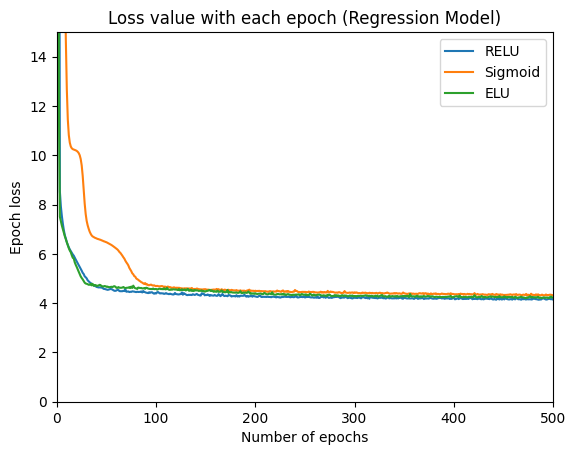

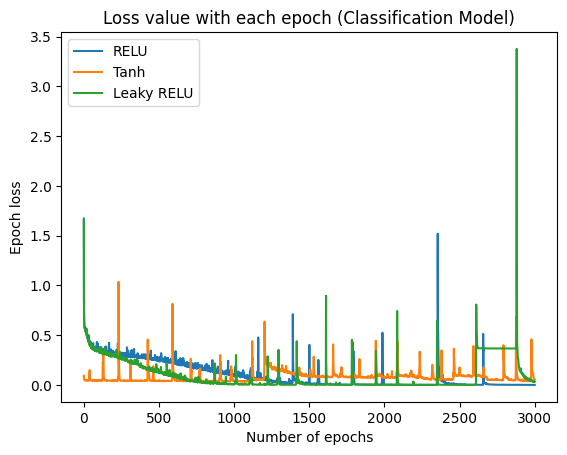

<Figure size 640x480 with 0 Axes>

In [33]:
import numpy as np
import matplotlib.pyplot as plt

epochs = np.arange(1, len(loss_list_regression) + 1)


plt.plot(epochs, relu_list_reg, label="RELU")
plt.plot(epochs, sigmoid_list_reg, label="Sigmoid")
plt.plot(epochs, elu_list_reg, label="ELU")
plt.xlabel("Number of epochs")
plt.ylabel("Epoch loss")
plt.xlim(0, 500)
plt.ylim(0, 15)
plt.title("Loss value with each epoch (Regression Model)")
plt.legend()
plt.show()
plt.clf()


plt.plot(epochs, relu_list_clf, label="RELU")
plt.plot(epochs, tanh_list_clf, label="Tanh")
plt.plot(epochs, leaky_relu_list_clf, label="Leaky RELU")
plt.xlabel("Number of epochs")
plt.ylabel("Epoch loss")
plt.title("Loss value with each epoch (Classification Model)")
plt.legend()
plt.show()
plt.clf()




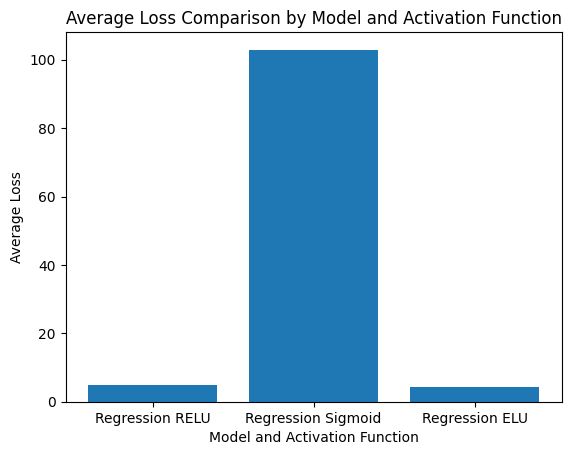

<Figure size 640x480 with 0 Axes>

In [30]:

# Define bar labels
bar_labels = ['Regression RELU', 'Regression Sigmoid', 'Regression ELU']

# Define bar heights
bar_heights = [relu_loss_reg, sigmoid_loss_reg, elu_loss_reg]

# Create bar plot
plt.bar(bar_labels, bar_heights)
plt.xlabel('Model and Activation Function')
plt.ylabel('Average Loss')
plt.title('Average Loss Comparison by Model and Activation Function')
plt.show()
plt.clf()

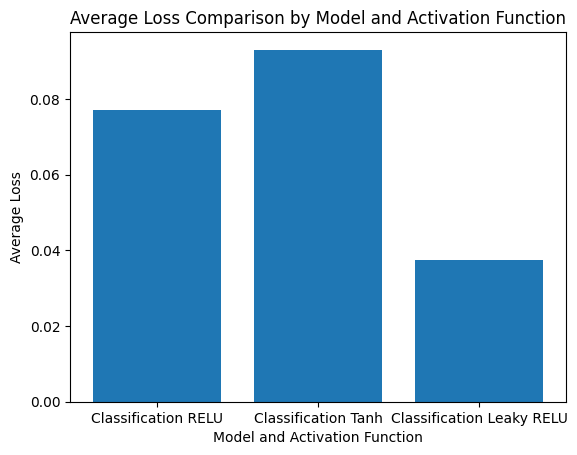

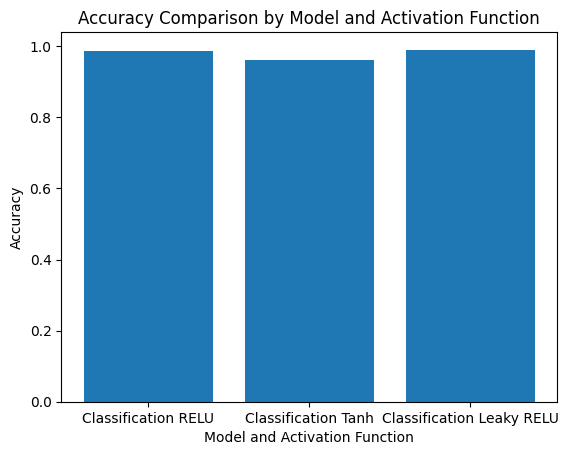

<Figure size 640x480 with 0 Axes>

In [31]:

# Define bar labels
bar_labels = ['Classification RELU', 'Classification Tanh', 'Classification Leaky RELU']

# Define bar heights
bar_heights = [relu_clf_loss, tanh_clf_loss, leaky_relu_clf_loss]

# Create bar plot
plt.bar(bar_labels, bar_heights)
plt.xlabel('Model and Activation Function')
plt.ylabel('Average Loss')
plt.title('Average Loss Comparison by Model and Activation Function')
plt.show()
plt.clf()


# Define bar labels
bar_labels = ['Classification RELU', 'Classification Tanh', 'Classification Leaky RELU']

# Define bar heights
bar_heights = [relu_clf_acc, tanh_clf_acc, leaky_relu_clf_acc]

# Create bar plot
plt.bar(bar_labels, bar_heights)
plt.xlabel('Model and Activation Function')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison by Model and Activation Function')
plt.show()
plt.clf()
